# Ramp 22 with variances + mean of abs(signal) + 1/zerocrossings OR threshold crossing

In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


## 1/ Zero crossings

In [2]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### 1/Zerocrossings
def inverse_zero(array):
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()
    
    return 1./zero_crossings

def generate_crossings_data(dir_path, time_range = None, window = 2000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(inverse_zero, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(inverse_zero, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(inverse_zero, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(inverse_zero, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(inverse_zero, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_inverse_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_inverse_crossings

def generate_data(dir_path, time_range, window = 2000, step = 10):
    
    moving_mean = generate_mean_data(dir_path, time_range, window = 2000, step = 10)
    moving_sd = generate_sd_data(dir_path, time_range, window = 2000, step = 10)
    moving_inverse_crossings = generate_crossings_data(dir_path, time_range, window = 2000, step = 10)
    time_label = load_time_label(dir_path, time_range, window = 2000, step = 10)
    
    all_data = np.concatenate((moving_mean, moving_sd, moving_inverse_crossings), axis = 1)
    
    %reset -f in
    
    return all_data, time_label

In [3]:
X_train, train_time = generate_data("./data/Ramp22/", time_range = (-450, -390), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp22/", time_range = (-20, 0), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (599800, 18)
X_test's shape:  (199800, 18)


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [5]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(12, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(12,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 117       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 63        
_________________________________________________________________
dense_5 (Dense)              (None, 12)                120       
_________________________________________________________________
dense_6 (Dense)              (None, 18)                234       
Total params: 822
Trainable params: 822
Non-trainable params: 0
____________________________

In [6]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 539820 samples, validate on 59980 samples
Epoch 1/50
539820/539820 [==============================] - 7s 12us/step - loss: 0.0023 - val_loss: 4.7862e-04
Epoch 2/50
539820/539820 [==============================] - 6s 11us/step - loss: 5.4346e-04 - val_loss: 3.8439e-04
Epoch 3/50
539820/539820 [==============================] - 5s 9us/step - loss: 3.9506e-04 - val_loss: 2.5456e-04
Epoch 4/50
539820/539820 [==============================] - 5s 9us/step - loss: 2.7980e-04 - val_loss: 1.6754e-04
Epoch 5/50
539820/539820 [==============================] - 5s 9us/step - loss: 2.0693e-04 - val_loss: 1.2831e-04
Epoch 6/50
539820/539820 [==============================] - 5s 9us/step - loss: 1.5480e-04 - val_loss: 9.4554e-05
Epoch 7/50
539820/539820 [==============================] - 4s 7us/step - loss: 1.0627e-04 - val_loss: 7.2135e-05
Epoch 8/50
539820/539820 [==============================] - 4s 7us/step - loss: 8.3583e-05 - val_loss: 6.8343e-05
Epoch 9/50
539820/539820 [=============

In [7]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [8]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

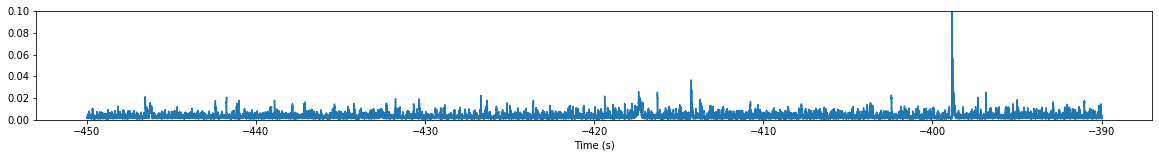

In [11]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 0.1])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

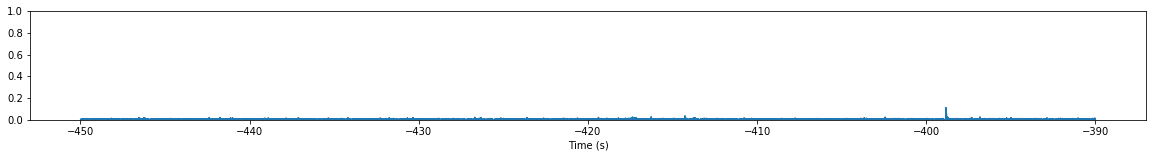

In [13]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 1])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

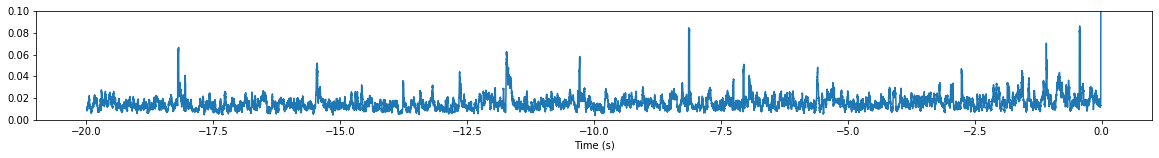

In [12]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0, 0.1])
#plt.xlim([-100,0])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

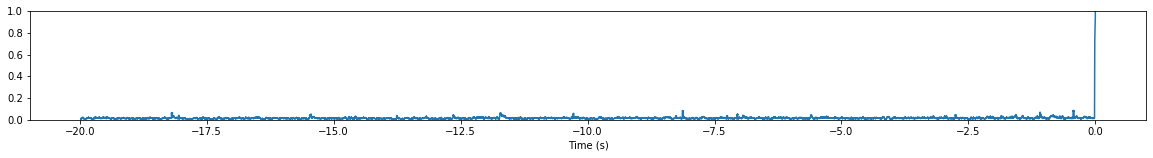

In [14]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0, 1])
#plt.xlim([-100,0])
plt.xlabel("Time (s)")

# threshold crossings

In [2]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

### Threshold crossings
def thres_cross(array):
    
    return (array > 0.01).sum()/array.size

def generate_thres_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).apply(thres_cross, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).apply(thres_cross, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).apply(thres_cross, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).apply(thres_cross, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).apply(thres_cross, raw = True).to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

def generate_data(dir_path, time_range, window = 2000, thres_win = 25000, step = 10):
    
    selection_index = int((thres_win - 2000)/10)
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = 10)[selection_index:]
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = 10)[selection_index:]
    moving_thres_crossings = generate_thres_data(dir_path, time_range, window = thres_win, step = 10)
    time_label = load_time_label(dir_path, time_range, window = window, step = 10)[selection_index:]
    
    all_data = np.concatenate((moving_mean, moving_sd, moving_thres_crossings), axis = 1)
    
    %reset -f in
    
    return all_data, time_label

In [3]:
X_train, train_time = generate_data("./data/Ramp22/", time_range = (-450, -390), window = 2000, step = 10)
X_test, test_time = generate_data("./data/Ramp22/", time_range = (-20, 0), window = 2000, step = 10)
print("X_train's shape: ", X_train.shape)
print("X_test's shape: ", X_test.shape)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
X_train's shape:  (597500, 18)
X_test's shape:  (197500, 18)


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [7]:
#================BUILD THE MODEL====================
print("Using Keras version: ", keras.__version__)

# Simple model
model = models.Sequential()

model.add(Dense(12, activation = 'elu', kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_dim=X_train.shape[1]))

model.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(6,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(9,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(12,activation='elu',
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

model.summary()

Using Keras version:  2.3.1
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 117       
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_10 (Dense)             (None, 9)                 63        
_________________________________________________________________
dense_11 (Dense)             (None, 12)                120       
_________________________________________________________________
dense_12 (Dense)             (None, 18)                234       
Total params: 822
Trainable params: 822
Non-trainable params: 0
____________________________

In [8]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=50
BATCH_SIZE=1028

history=model.fit(X_train, X_train,
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  verbose = 1)

Train on 537750 samples, validate on 59750 samples
Epoch 1/50
537750/537750 [==============================] - 5s 9us/step - loss: 6.6126e-04 - val_loss: 9.1111e-05
Epoch 2/50
537750/537750 [==============================] - 4s 8us/step - loss: 9.9918e-05 - val_loss: 4.4389e-05
Epoch 3/50
537750/537750 [==============================] - 4s 8us/step - loss: 5.5448e-05 - val_loss: 3.3897e-05
Epoch 4/50
537750/537750 [==============================] - 5s 9us/step - loss: 4.2834e-05 - val_loss: 3.2314e-05
Epoch 5/50
537750/537750 [==============================] - 4s 8us/step - loss: 3.9095e-05 - val_loss: 3.1372e-05
Epoch 6/50
537750/537750 [==============================] - 5s 8us/step - loss: 3.6527e-05 - val_loss: 2.9831e-05
Epoch 7/50
537750/537750 [==============================] - 5s 10us/step - loss: 3.3809e-05 - val_loss: 2.8880e-05
Epoch 8/50
537750/537750 [==============================] - 4s 7us/step - loss: 3.1472e-05 - val_loss: 2.6806e-05
Epoch 9/50
537750/537750 [==========

In [9]:
X_pred = model.predict(X_train)
scored = pd.DataFrame()
scored['Loss_mse'] = np.mean(np.abs(X_pred-X_train), axis = 1)

In [10]:
X_pred_test = model.predict(X_test)
scored_test = pd.DataFrame()
scored_test['Loss_mse'] = np.mean(np.abs(X_pred_test-X_test), axis = 1)

Text(0.5, 0, 'Time (s)')

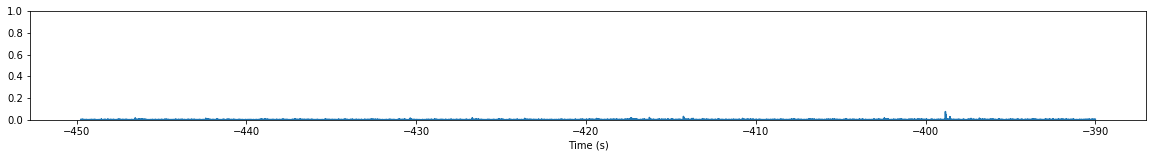

In [16]:
plt.figure(figsize=(20,2))
plt.plot(train_time, scored['Loss_mse'])
plt.ylim([0, 1])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

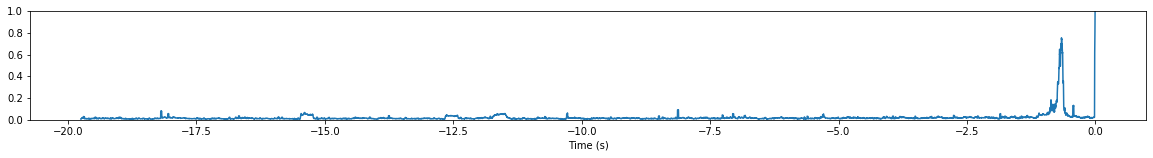

In [15]:
plt.figure(figsize=(20,2))
plt.plot(test_time, scored_test['Loss_mse'])
plt.ylim([0, 1])
#plt.xlim([-100,0])
plt.xlabel("Time (s)")